In [3]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


# Demo 5

In [205]:
reset_graph()
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Network architecture

In [ ]:
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, [None, 784])
y_true = tf.placeholder(tf.float32, [None, 10])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024]) ## 7x7 will be the size of the output image
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

## Train the model

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    acc=np.zeros(2000)
    for i in range(2000):
        batch = mnist.train.next_batch(50)
        if i % 200 == 0:
            train_accuracy = accuracy.eval(feed_dict={
              x: batch[0], y_true: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_true: batch[1], keep_prob: 0.5})
        acc[i]=accuracy.eval(feed_dict={x:batch[0], y_true: batch[1], keep_prob: 1.0})
    print('test accuracy %g' % accuracy.eval(feed_dict={
        x: mnist.test.images, y_true: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.1
step 200, training accuracy 0.98
step 400, training accuracy 0.98
step 600, training accuracy 0.98
step 800, training accuracy 0.9
step 1000, training accuracy 0.92
step 1200, training accuracy 0.98
step 1400, training accuracy 0.98
step 1600, training accuracy 0.96


## Example 2. Classifying large images using Inception v3.

Download some images of various animals. Load them in Python, for example using the matplotlib.image.mpimg.imread() function or the scipy.misc.imread() function. Resize and/or crop them to 299 × 299 pixels, and ensure that they have just three channels (RGB), with no transparency channel. The images that the Inception model was trained on were preprocessed so that their values range from -1.0 to 1.0, so you must ensure that your images do too

### Inception v3


<img src=https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png >

In [4]:
import os
width = 299
height = 299
channels = 3

### Example images

Ensure that the values are in the range [-1, 1] (as expected by the pretrained Inception model), instead of [0, 1]:

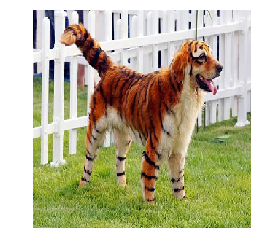

0.984375


In [60]:
from PIL import Image
import scipy.misc


test_image = Image.open(os.path.join("./","test_image4.jpeg"))
test_image = test_image.resize((height, width))      # optional, to reduce time
test_image = scipy.misc.fromimage(test_image)

plt.imshow(test_image)
plt.axis("off")
plt.show()

test_image = 2 * test_image/128 - 1
print(np.max(test_image))

Download the latest pretrained Inception v3 model: the checkpoint is available at https://github.com/tensorflow/models/tree/master/research/slim. The list of class names is available at https://goo.gl/brXRtZ, but you must insert a "background" class at the beginning.


In [6]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [7]:
fetch_pretrained_inception_v3()

In [8]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [9]:
class_names = ["background"] + load_class_names()

In [10]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

Exercise: Create the Inception v3 model by calling the `inception_v3()` function, as shown below. This must be done within an argument scope created by the `inception_v3_arg_scope()` function. Also, you must set `is_training=False` and `num_classes=1001` [...]

In [11]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

Exercise: Open a session and use the `Saver` to restore the pretrained model checkpoint you downloaded earlier.


In [12]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    # ...

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


Run the model to classify the images you prepared. Display the top five predictions for each image, along with the estimated probability (the list of class names is available at https://goo.gl/brXRtZ). How accurate is the model?

In [61]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [62]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

717

In [63]:
class_names[most_likely_class_index]

'picket fence, paling'

In [64]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

picket fence, paling: 87.12%
worm fence, snake fence, snake-rail fence, Virginia fence: 3.46%
poncho: 1.64%
maypole: 0.30%
stole: 0.23%


<img src="./cnns.jpg">